In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import glob
import os
import geopandas as gpd
from plotnine import *
import matplotlib.dates as mdates
import numpy as np
from plotnine import ggplot, aes, geom_line, geom_point, theme_bw, labs
from scipy.interpolate import PchipInterpolator

# Initial Visualization: Time series of Yield

In [2]:
results = pd.read_parquet("/workspace/workflow/_6EvaluationNotebooks/results.parquet", engine="fastparquet")

results["Clock.Today"] = pd.to_datetime(results["Clock.Today"])

possible_vars = ['MaizeYield','SoyBeanYield','Yield','Nitrogen_Sowing']

@interact(variable=possible_vars)
def plot_variable(variable="SurfaceOrganicMatter.Cover"):
    pivot_df = results.pivot_table(
        index="Clock.Today",
        columns="Nitrogen",
        values=variable,
        aggfunc="max"
    )

    plt.figure(figsize=(12, 6))
    for col in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[col], label=f"Nitrogen {col}")

    # Force all years on x-axis
    years = pd.DatetimeIndex(pivot_df.index).year.unique()
    plt.xticks(pd.to_datetime([f'{year}-01-01' for year in years]), years, rotation=45)

    plt.xlabel("Year")
    plt.ylabel(variable)
    plt.title(f"{variable} over time")
    plt.legend(title="Simulation", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


interactive(children=(Dropdown(description='variable', options=('MaizeYield', 'SoyBeanYield', 'Yield', 'Nitrog…

# PAPER VISUALIZATIONS

In [151]:
results = pd.read_parquet("/workspace/workflow/_6EvaluationNotebooks/results.parquet", engine="fastparquet")
GTD=pd.read_csv("/workspace/workflow/_6EvaluationNotebooks/GTD.csv")
folder = "/workspace/workflow/_3AgroDataExtraction"
geojson_file = glob.glob(os.path.join(folder, "*.geojson"))
fields=gpd.read_file(geojson_file[0])
fields_region=fields[['id_cell','id_within_cell','region']]
fields_region_indexed = fields_region.set_index(['id_cell', 'id_within_cell'])

# Preparing Simulations
results["Clock.Today"] = pd.to_datetime(results["Clock.Today"])
results['Year'] = results['Clock.Today'].dt.year
idx = results.groupby(['id_cell', 'Nitrogen','Year'])['Yield'].idxmax()
results = results.loc[idx].reset_index(drop=True)

## Selecting important variables
results = results[['id_cell','id_within_cell','Nitrogen','Yield','Year','MaizeYield']]

results_region = results.join(fields_region_indexed, on=['id_cell', 'id_within_cell'])

mask_c= (results_region['region'] == 'C') & (results_region['Year'] < 2014)
## Deleting years 2019 and 2020 (No have GTD for these years)

mask_other= (results_region['region'] != 'C') & (results_region['Year'] < 2019)

results_region_filtered_c= results_region[mask_c]
results_region_filtered_other= results_region[mask_other]

results_region_filtered=results_region_filtered_c.merge(results_region_filtered_other,how='outer')

# Selecting only the years where corn was produced
results_region_filtered=results_region_filtered[results_region_filtered['MaizeYield']!=0]

# Preparing Ground Truth
mask_GTD=(GTD['year'] < 2019) 
GTD_filtered = GTD[mask_GTD]
GTD_filtered['Yield'] = GTD_filtered['yield_ton']  
GTD_filtered['Nitrogen'] = GTD_filtered['NKg_Ha'] 
GTD_filtered=GTD_filtered[['Nitrogen','Yield','region']]

/tmp/ipykernel_63264/3780772854.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_63264/3780772854.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [152]:
results_region_filtered['Yield']=results_region_filtered['Yield'].round(1)
idx_max_yield=results_region_filtered.groupby('id_cell')['Yield'].idxmax()
max_yield_df = results_region_filtered.loc[idx_max_yield, ['id_cell', 'Nitrogen']].set_index('id_cell')

# Map Nitrogen at max yield back to original DataFrame
results_region_filtered['nrate_max_yield'] = results_region_filtered['id_cell'].map(max_yield_df['Nitrogen'])

results_region_filtered

,id_cell,id_within_cell,Nitrogen,Yield,Year,MaizeYield,region,nrate_max_yield
4,0,2,0,6.4,2012,6424.183,NC,100
7,0,2,0,8.1,2010,8112.552,NC,100
8,0,2,0,8.4,2014,8377.986,NC,100
9,0,2,0,8.7,2016,8697.723,NC,100
10,0,2,0,9.3,2018,9292.649,NC,100
...,...,...,...,...,...,...,...,...
47658,1300,1,300,8.8,2007,8767.066,NE,300
47659,1300,1,300,12.5,2009,12469.760,NE,300
47660,1300,1,300,13.6,2013,13592.271,NE,300
47661,1300,1,300,15.1,2017,15081.324,NE,300


In [153]:
counts1 = (
    results_region_filtered
    .groupby(['region', 'nrate_max_yield'])
    .size()   # count rows in each group
    .reset_index(name='count')  # convert to DataFrame with column 'count'
)
counts1['Source']='Simulated'

In [154]:
GTD_filtered['id_real']=np.arange(len(GTD_filtered))//4
GTD_filtered['Yield']=GTD_filtered['Yield'].astype(int)
idx_max_yield=GTD_filtered.groupby('id_real')['Yield'].idxmax()
max_yield_df = GTD_filtered.loc[idx_max_yield, ['id_real', 'Nitrogen']].set_index('id_real')


GTD_filtered['nrate_max_yield'] = GTD_filtered['id_real'].map(max_yield_df['Nitrogen'])

counts2 = (
    GTD_filtered
    .groupby(['region', 'nrate_max_yield'])
    .size()   # count rows in each group
    .reset_index(name='count')  # convert to DataFrame with column 'count'
)
counts2['Source']='Ground Truth'

In [155]:
counts=pd.concat([counts1,counts2])
counts['total']=counts.groupby(['region','Source'])['count'].transform('sum')
counts['percentage']=counts['count']/counts['total']*100
counts

,region,nrate_max_yield,count,Source,total,percentage
0,C,0,112,Simulated,2416,4.635762
1,C,100,672,Simulated,2416,27.814570
2,C,200,800,Simulated,2416,33.112583
3,C,300,832,Simulated,2416,34.437086
4,NC,0,1148,Simulated,17171,6.685691
5,NC,100,1220,Simulated,17171,7.105003
6,NC,200,5240,Simulated,17171,30.516569
7,NC,300,9563,Simulated,17171,55.692738
8,NE,0,148,Simulated,4922,3.006908
9,NE,100,584,Simulated,4922,11.865095


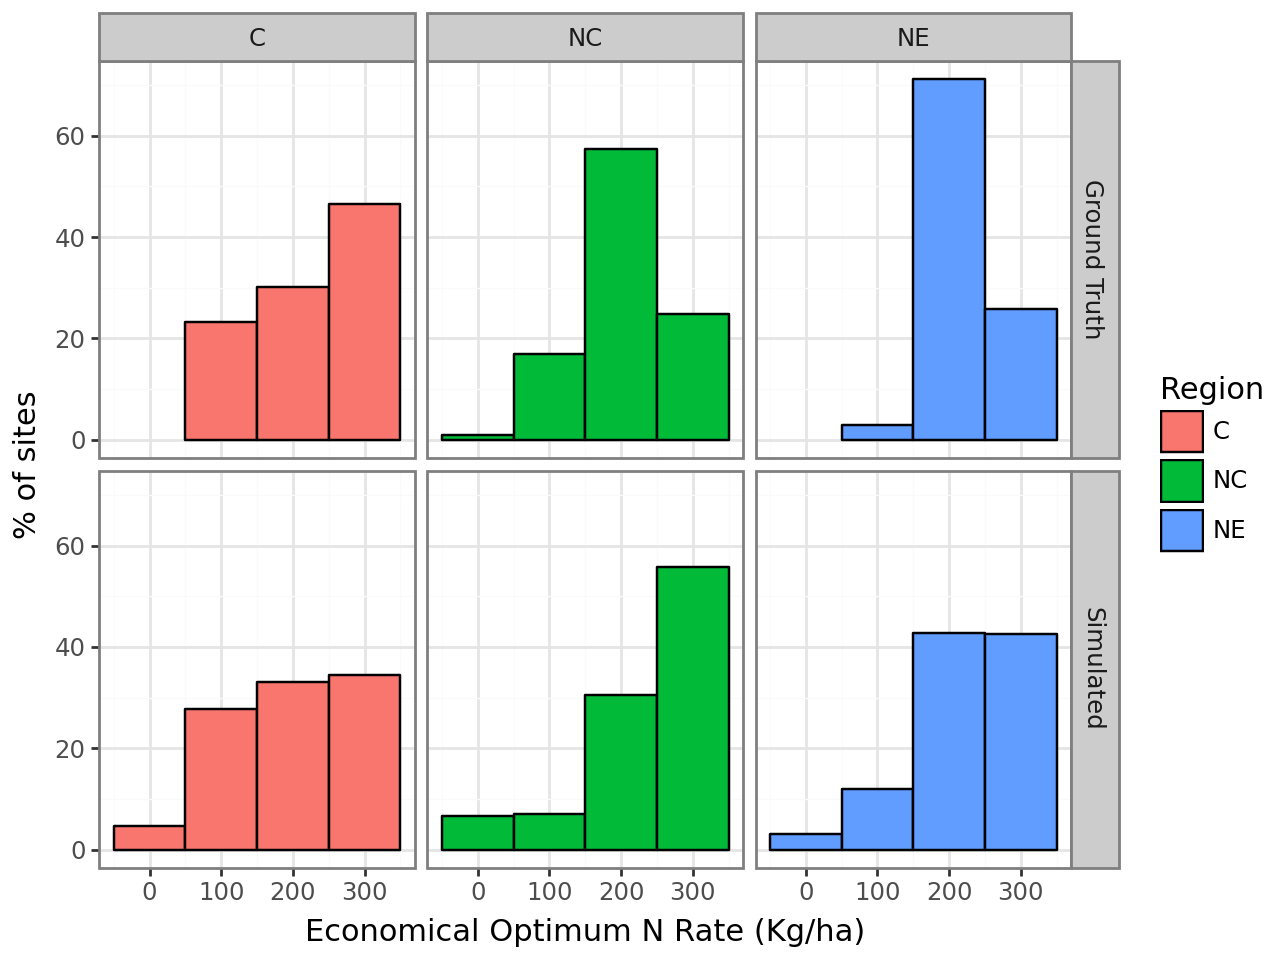

In [156]:
p = (
    ggplot(counts, aes(x='nrate_max_yield',y='percentage',fill='region'))
    + geom_col(position='dodge', width=100,color='black')
    + theme_bw()
    + facet_grid('Source~region')
    + labs(x='Economical Optimum N Rate (Kg/ha)',y="% of sites",fill='Region')
)

p

In [158]:
!python -m _6EvaluationNotebooks

/usr/local/bin/python: No module named _6EvaluationNotebooks
